### Please save credentials with test before running this

In [65]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.tools.visualization import plot_histogram
from numpy import pi
from gates import *


## Define circuit

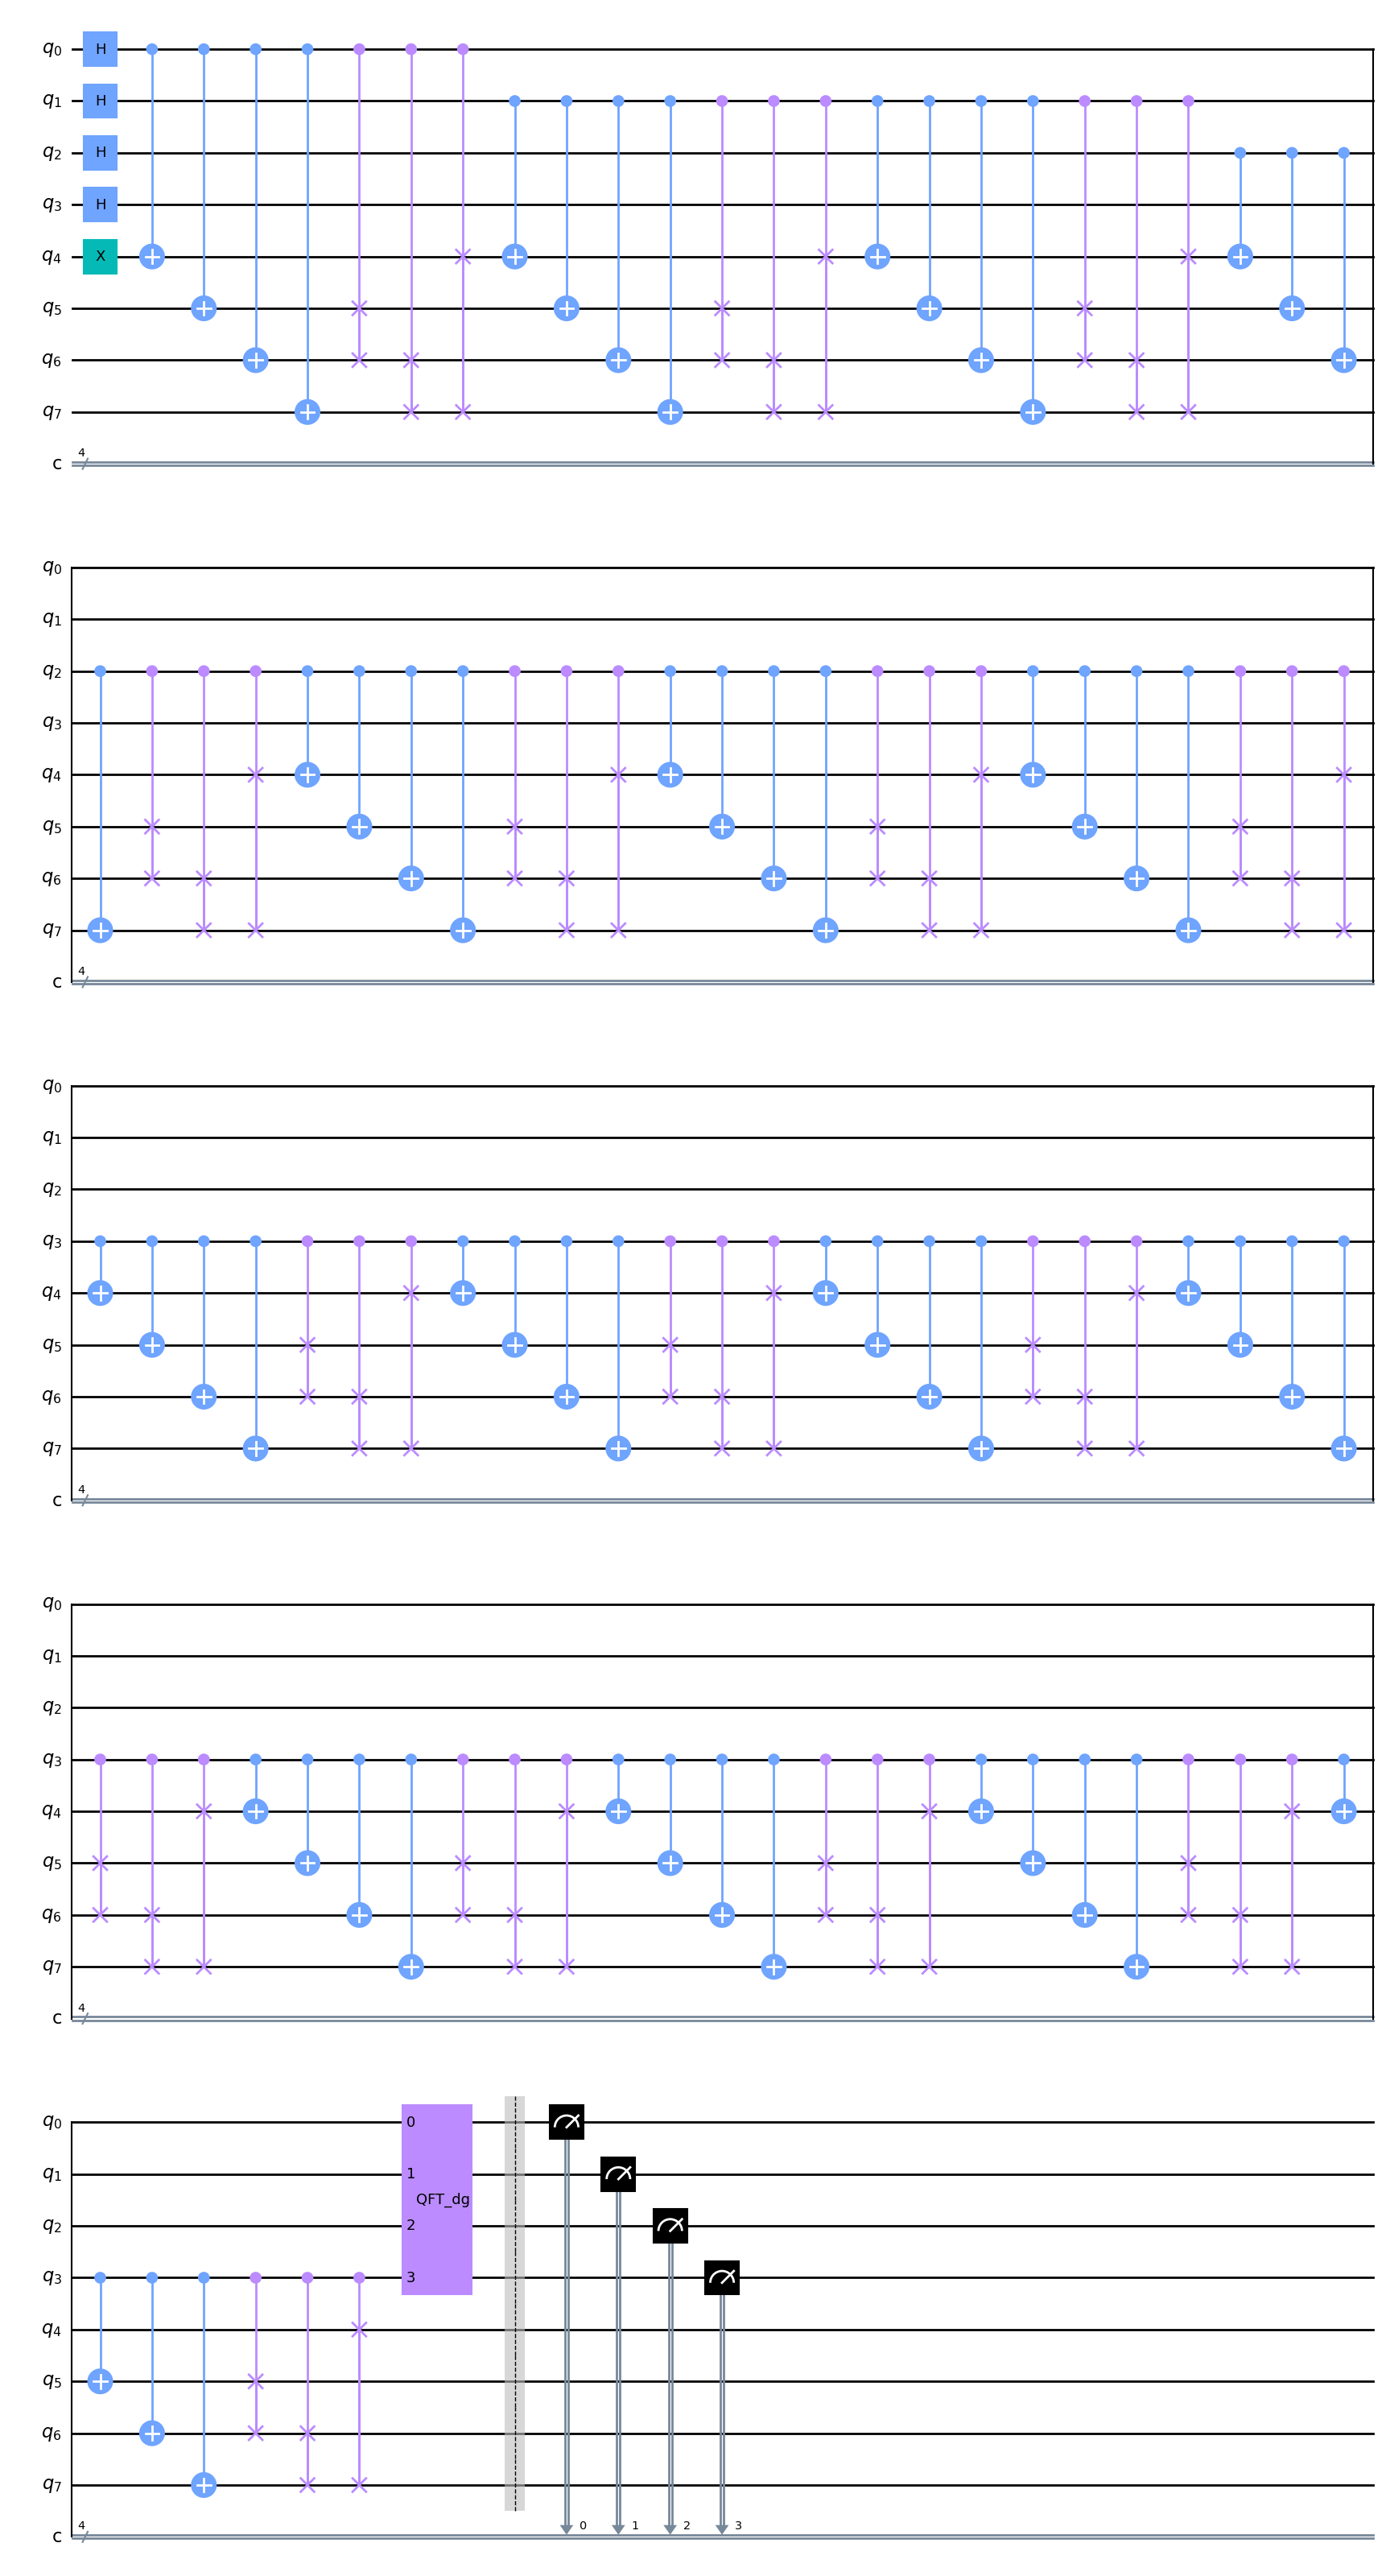

In [87]:
circ = QuantumCircuit(8, 4)

circ.h(range(4))
circ.x(4)

# Compute modular exponentiation for this particular choice
#circ.append(c_7mod15_gate(1), [0, 4, 5, 6, 7])
# fixme in pratica queste sono gate ccx, che sono diverse da gate cx, quindi non si riesce
for _ in range(1):
  for i in range(4, 8):
    circ.cx(0, i)
  circ.cswap(0, 5, 6)
  circ.cswap(0, 6, 7)
  circ.cswap(0, 4, 7)
#circ.append(c_7mod15_gate(2), [1, 4, 5, 6, 7])
for _ in range(2):
  for i in range(4, 8):
    circ.cx(1, i)
  circ.cswap(1, 5, 6)
  circ.cswap(1, 6, 7)
  circ.cswap(1, 4, 7)
#circ.append(c_7mod15_gate(4), [2, 4, 5, 6, 7])
for _ in range(4):
  for i in range(4, 8):
    circ.cx(2, i)
  circ.cswap(2, 5, 6)
  circ.cswap(2, 6, 7)
  circ.cswap(2, 4, 7)
#circ.append(c_7mod15_gate(8), [3, 4, 5, 6, 7])
for _ in range(8):
  for i in range(4, 8):
    circ.cx(3, i)
  circ.cswap(3, 5, 6)
  circ.cswap(3, 6, 7)
  circ.cswap(3, 4, 7)

circ.append(qft_gate(4).inverse(), range(4))

circ.barrier(range(8))
circ.measure(range(4), range(4))
circ.draw("mpl")


## Test circuit


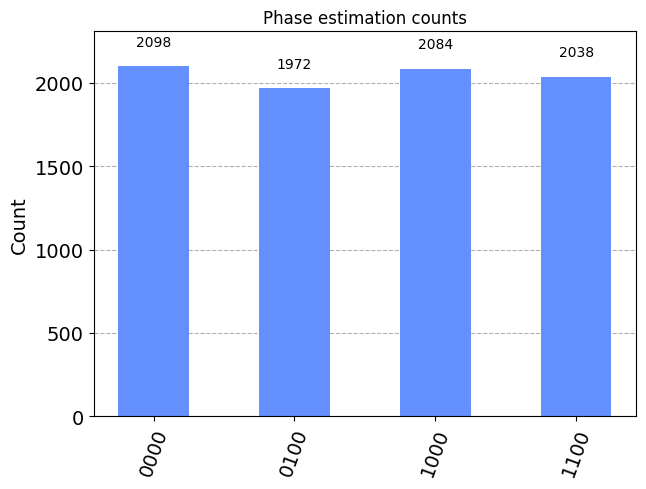

In [88]:
simulator = Aer.get_backend('aer_simulator')
transpiled_circ = transpile(circ, simulator)
result = simulator.run(transpiled_circ, shots=8192).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='Phase estimation counts')


## Run on IBM (This costs money)


In [73]:
service = QiskitRuntimeService("ibm_cloud")
backend = service.backend("aaa")

options=Options()
#options.max_execution_time=5
options.execution.shots=2

job = Sampler(backend, options=options).run(circ)
print(f"job id: {job.job_id()}")
phase_estimation_result = job.result()
print(phase_estimation_result)
counts = phase_estimation_result.quasi_dists[0]
plot_histogram(counts, title='Phase estimation counts')

QiskitBackendNotFoundError: 'No backend matches the criteria. Learn more about available backends here https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-choose-backend '

In [97]:
result = transpile(circ, basis_gates=["cx", "id", "rz", "sx", "x"], optimization_level=2, seed_transpiler=1)
#result.draw("mpl")


In [98]:
result.count_ops()


OrderedDict([('rz', 414),
             ('cx', 372),
             ('sx', 98),
             ('measure', 4),
             ('x', 1),
             ('barrier', 1)])